# Week 5 — Hybrid Retrieval Evaluation

This notebook reports Recall@k for vector-only, keyword-only, and hybrid (RRF) search on ≥10 queries.

In [3]:
!pip install --quiet \
    numpy \
    matplotlib \
    scikit-learn \
    fastapi \
    uvicorn \
    faiss-cpu \
    rank-bm25 \
    nbformat \
    sentence-transformers \
    sqlite-utils

In [4]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

from hybrid_search import hybrid_search, vector_search, keyword_search
from hybrid_index import DEFAULT_DB, connect

def title_of(doc_id:int):
    conn = connect(DEFAULT_DB); cur = conn.cursor()
    cur.execute("SELECT title FROM documents WHERE doc_id=?", (doc_id,))
    row = cur.fetchone(); conn.close()
    return row[0] if row else "?"


## Corpus sanity check

In [5]:
conn = sqlite3.connect(DEFAULT_DB)
docs = conn.execute("SELECT doc_id, year, title FROM documents ORDER BY doc_id").fetchall()
conn.close()
len(docs), docs[:5]

(16,
 [(1, 2003, 'About compression of vocabulary in computer oriented languages'),
  (2, 2003, 'Glottochronology and problems of protolanguage reconstruction'),
  (3, 2003, 'Glottochronologic Retrognostic of Language System'),
  (4, 2008, 'The emerging field of language dynamics'),
  (5, 2011, 'Entropy of Telugu')])

## Gold labels (query → relevant doc_id list)

These IDs match the current index.

In [6]:
gold = {
    "compression of vocabulary in computer languages": [1],
    "glottochronology protolanguage reconstruction": [2, 3],
    "language dynamics field": [4],
    "entropy of telugu": [5],
    "semantic parsing framework cornell spf": [6],
    "deep learning for nlp notes": [7],
    "meta learning for machine translation metamT": [8],
    "spoken italian treebank kiparla": [9],
    "cluster automata": [10],
    "conclusive remark on language modeling": [11],
    "sense of humour in computers": [12],
    "ukrainian writing system properties": [14],
    "richard berry paradox formal semantics": [15],
    "standardization of lexical information for nlp": [16],
}
len(gold)

14

## Recall@k computation & run experiments

In [7]:
def recall_at_k(run_hits, gold, k:int=3):
    total = len(gold)
    hits = 0
    for q, rel in gold.items():
        pred = run_hits.get(q, [])[:k]
        if any(d in rel for d in pred):
            hits += 1
    return hits / max(1, total)

def evaluate(k:int=3, fusion:str="rrf"):
    vec_run, key_run, hyb_run = {}, {}, {}
    for q in gold:
        vec = vector_search(q, top_k=k)
        key = keyword_search(q, top_k=k)
        hyb = hybrid_search(q, k=k, fusion=fusion)
        vec_run[q] = [h.doc_id for h in vec]
        key_run[q] = [h.doc_id for h in key]
        hyb_run[q] = [h["doc_id"] for h in hyb["hybrid_hits"]]
    return vec_run, key_run, hyb_run

k = 3
vec_run, key_run, hyb_run = evaluate(k=k, fusion="rrf")
rec_vec = recall_at_k(vec_run, gold, k)
rec_key = recall_at_k(key_run, gold, k)
rec_hyb = recall_at_k(hyb_run, gold, k)
rec_vec, rec_key, rec_hyb

(1.0, 1.0, 1.0)

## Plot Recall@3

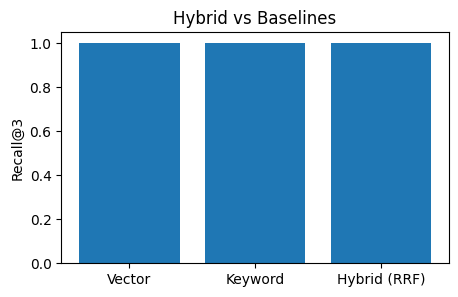

In [8]:
labels = ["Vector", "Keyword", "Hybrid (RRF)"]
vals = [rec_vec, rec_key, rec_hyb]
plt.figure(figsize=(5,3))
plt.bar(labels, vals)
plt.ylim(0, 1.05)
plt.ylabel("Recall@3")
plt.title("Hybrid vs Baselines")
plt.show()

## Example per-query hits (top-3)

In [9]:
for q in list(gold.keys())[:5]:
    vec = vector_search(q, top_k=3)
    key = keyword_search(q, top_k=3)
    hyb = hybrid_search(q, k=3, fusion="rrf")
    print("\n===", q, "===")
    print("rel:", [(d, title_of(d)) for d in gold[q]])
    print("vec:", [(h.doc_id, title_of(h.doc_id)) for h in vec])
    print("key:", [(h.doc_id, title_of(h.doc_id)) for h in key])
    print("hyb:", [(h['doc_id'], title_of(h['doc_id'])) for h in hyb['hybrid_hits']])


=== compression of vocabulary in computer languages ===
rel: [(1, 'About compression of vocabulary in computer oriented languages')]
vec: [(1, 'About compression of vocabulary in computer oriented languages'), (1, 'About compression of vocabulary in computer oriented languages'), (1, 'About compression of vocabulary in computer oriented languages')]
key: [(1, 'About compression of vocabulary in computer oriented languages'), (1, 'About compression of vocabulary in computer oriented languages')]
hyb: [(1, 'About compression of vocabulary in computer oriented languages'), (1, 'About compression of vocabulary in computer oriented languages'), (1, 'About compression of vocabulary in computer oriented languages')]

=== glottochronology protolanguage reconstruction ===
rel: [(2, 'Glottochronology and problems of protolanguage reconstruction'), (3, 'Glottochronologic Retrognostic of Language System')]
vec: [(3, 'Glottochronologic Retrognostic of Language System'), (4, 'The emerging field of 